# Sistem Prediksi Keterlambatan Karyawan dengan Integrasi Data Cuaca

Notebook ini mengimplementasikan sistem prediksi keterlambatan karyawan yang mempertimbangkan:
1. Data historis kehadiran karyawan
2. Kondisi cuaca real-time dari OpenWeather API
3. Model machine learning berbasis PyTorch
4. Aturan toleransi berbasis cuaca (5 menit untuk hujan, 1 menit untuk cerah)

Proses yang dilakukan:
1. Persiapan dan pembersihan data
2. Feature engineering
3. Pembuatan dan pelatihan model
4. Implementasi API untuk prediksi real-time
5. Integrasi dengan sistem geolokasi

Kasus penggunaan:
- Memprediksi kemungkinan keterlambatan karyawan
- Memberikan toleransi waktu berdasarkan cuaca
- Memvalidasi lokasi kehadiran karyawan

# 1. Import Library dan Konfigurasi API


## 1.1 Import Library yang Diperlukan
- pandas & numpy: untuk manipulasi data
- requests: untuk mengambil data cuaca dari API
- sklearn: untuk preprocessing data dan evaluasi model
- tensorflow: untuk membuat dan melatih model neural network
- flask: untuk membuat API endpoint
- geopy: untuk perhitungan jarak geografis

In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data structure example from backend:
"""
{
    "message": "Absence recorded successfully",
    "data": {
        "id": 1,
        "id_karyawan": 1,
        "nama_karyawan": "Staff Baru",
        "tanggal": "2025-06-08T00:00:00Z",
        "jam_masuk": "17:15:03",
        "jam_jadwal": "09:00:00",
        "terlambat": true,
        "cuaca": "Clouds",
        "latitude": -8.1178,
        "longitude": 115.0919,
        "hari": "Sunday",
        "created_at": "2025-06-08T17:15:03.176529Z"
    }
}
"""

'\n{\n    "message": "Absence recorded successfully",\n    "data": {\n        "id": 1,\n        "id_karyawan": 1,\n        "nama_karyawan": "Staff Baru",\n        "tanggal": "2025-06-08T00:00:00Z",\n        "jam_masuk": "17:15:03",\n        "jam_jadwal": "09:00:00",\n        "terlambat": true,\n        "cuaca": "Clouds",\n        "latitude": -8.1178,\n        "longitude": 115.0919,\n        "hari": "Sunday",\n        "created_at": "2025-06-08T17:15:03.176529Z"\n    }\n}\n'

#2. Data Loading


## 2.1 Load Dataset
- Membaca file CSV absensi
- Mengkonversi kolom tanggal dan waktu ke format yang sesuai
- Menyiapkan fungsi untuk mengambil data cuaca

Input data yang digunakan:
- tanggal: tanggal kehadiran
- jam_masuk: waktu kedatangan karyawan
- jam_jadwal: waktu yang dijadwalkan
- cuaca: kondisi cuaca saat itu
- terlambat: status keterlambatan (1 = terlambat, 0 = tepat waktu)
- hari : hari saat itu

In [69]:
# Load attendance data
df = pd.read_csv('c:/Users/Asus/OneDrive - student.gunadarma.ac.id/Documents/DICODING/DBS/CAPSTONE/modeling/datasets/[3] clean/clean_absensi.csv')

df.head()

,tanggal,id_karyawan,nama_karyawan,jam_masuk,jam_jadwal,terlambat,cuaca,hari
0,2024-05-21,9,Karyawan_9,08:34,08:00,1,Hujan,Tuesday
1,2024-04-01,12,Karyawan_12,08:41,08:00,1,Berawan,Monday
2,2024-06-24,8,Karyawan_8,08:06,08:00,1,Cerah,Monday
3,2024-03-02,11,Karyawan_11,07:56,08:00,0,Hujan,Saturday
4,2024-06-07,15,Karyawan_15,08:55,08:00,1,Hujan,Friday


In [70]:
df.describe()

,id_karyawan,terlambat
count,2000.000000,2000.000000
mean,10.619000,0.794000
std,5.732213,0.404532
min,1.000000,0.000000
25%,6.000000,1.000000
50%,11.000000,1.000000
75%,16.000000,1.000000
max,20.000000,1.000000


# 3. Data Preparation

Melakukan pembersihan data:
1. Mengecek missing values
2. Mengecek dan menangani data duplikat
3. Mengecek distribusi data
4. Menangani outliers jika ada

## 3.1 Missing Values Check


In [71]:
# 1. Missing Values Check
print("=== Missing Values Check ===")
print(df.isnull().sum())

=== Missing Values Check ===
tanggal          0
id_karyawan      0
nama_karyawan    0
jam_masuk        0
jam_jadwal       0
terlambat        0
cuaca            0
hari             0
dtype: int64


## 3.2 Handle Data Duplicate

In [72]:
print("\n=== Duplicate Check ===")
print(df.duplicated().sum())


=== Duplicate Check ===
0


## 3.3 Mengubah Tipe Data


In [73]:
# Convert time columns to datetime
df['tanggal'] = pd.to_datetime(df['tanggal'])
df['jam_masuk'] = pd.to_datetime(df['jam_masuk'], format='%H:%M')
df['jam_jadwal'] = pd.to_datetime(df['jam_jadwal'], format='%H:%M')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tanggal        2000 non-null   datetime64[ns]
 1   id_karyawan    2000 non-null   int64         
 2   nama_karyawan  2000 non-null   object        
 3   jam_masuk      2000 non-null   datetime64[ns]
 4   jam_jadwal     2000 non-null   datetime64[ns]
 5   terlambat      2000 non-null   int64         
 6   cuaca          2000 non-null   object        
 7   hari           2000 non-null   object        
dtypes: datetime64[ns](3), int64(2), object(3)
memory usage: 125.1+ KB


## 3.4 Data Distribution


In [74]:
print("\n=== Data Distribution ===")
print("\nWeather distribution:")
print(df['cuaca'].value_counts())

print("\nDay of week distribution:")
print(df['tanggal'].dt.dayofweek.value_counts().sort_index())

print("\nLate vs On-time distribution:")
print(df['terlambat'].value_counts())


=== Data Distribution ===

Weather distribution:
cuaca
Hujan      708
Berawan    682
Cerah      610
Name: count, dtype: int64

Day of week distribution:
tanggal
0    313
1    286
2    289
3    281
4    277
5    287
6    267
Name: count, dtype: int64

Late vs On-time distribution:
terlambat
1    1588
0     412
Name: count, dtype: int64


## 3.5 Prepare Features


In [75]:
# Prepare features
def prepare_features(df):
    # 1. Time-based features
    # Convert time to minutes since midnight
    df['arrival_time'] = pd.to_datetime(df['jam_masuk'].astype(str)).dt.hour * 60 + pd.to_datetime(df['jam_masuk'].astype(str)).dt.minute
    df['scheduled_time'] = pd.to_datetime(df['jam_jadwal'].astype(str)).dt.hour * 60 + pd.to_datetime(df['jam_jadwal'].astype(str)).dt.minute

    # Time difference from scheduled time
    df['time_diff'] = df['arrival_time'] - df['scheduled_time']

    # 2. Day-based features
    # Add day of week (0-6)
    df['day_of_week'] = df['tanggal'].dt.dayofweek

    # Is weekend
    df['is_weekend'] = df['tanggal'].dt.dayofweek.isin([5, 6]).astype(int)

    # Is Monday or Friday (typically problematic days)
    df['is_monday'] = (df['tanggal'].dt.dayofweek == 0).astype(int)
    df['is_friday'] = (df['tanggal'].dt.dayofweek == 4).astype(int)

    # 3. Weather-based features
    # Basic weather encoding
    weather_map = {
        'Cerah': 0,
        'Berawan': 1,
        'Hujan': 2,
        'Thunderstorm': 3
    }
    df['weather_encoded'] = df['cuaca'].map(weather_map)

    # One-hot encode weather
    weather_dummies = pd.get_dummies(df['weather_encoded'], prefix='weather')
    df = pd.concat([df, weather_dummies], axis=1)

    # 4. Historical patterns
    # Previous day's lateness (if available)
    df['prev_day_late'] = df.sort_values('tanggal').groupby('id_karyawan')['terlambat'].shift(1).fillna(0)

    # Rolling average of lateness (last 7 days)
    df['late_7day_avg'] = df.sort_values('tanggal').groupby('id_karyawan')['terlambat'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)

    # 5. Define target
    df['is_late'] = df['terlambat']

    return df

# Prepare the data
df_prepared = prepare_features(df)



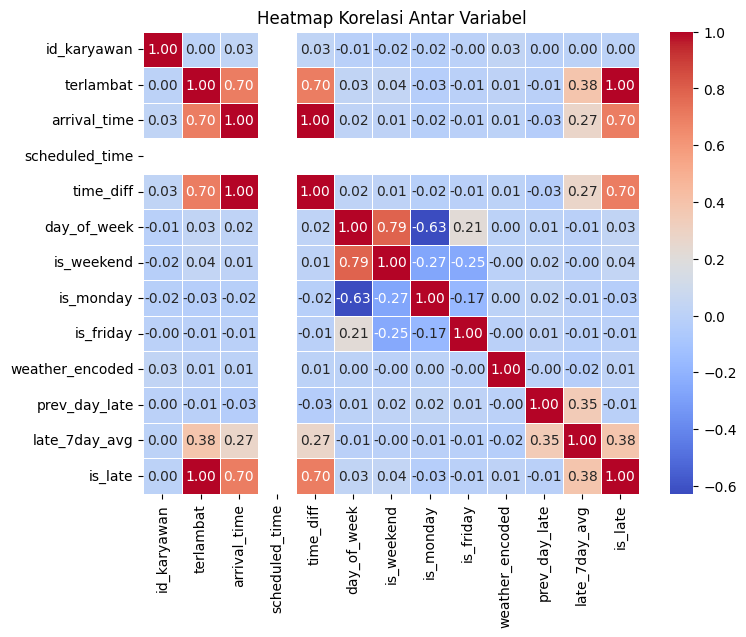

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung korelasi
df_numeric = df_prepared.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

In [77]:
# Select features for model
print("\n=== Memilih Fitur ===")
base_features = [
    'day_of_week',
    'scheduled_time',
    'is_weekend',
    'is_monday',
    'is_friday',
    'prev_day_late',
    'late_7day_avg'
]

weather_columns = [col for col in df_prepared.columns if col.startswith('weather_')]
features = base_features + weather_columns

print("Final selected features:", features)
print("Number of features:", len(features))

# Display sample data for selected features
print("\n=== Sampel Data untuk Fitur yang Dipilih ===")
print(df_prepared[features].head())


=== Memilih Fitur ===
Final selected features: ['day_of_week', 'scheduled_time', 'is_weekend', 'is_monday', 'is_friday', 'prev_day_late', 'late_7day_avg', 'weather_encoded', 'weather_0', 'weather_1', 'weather_2']
Number of features: 11

=== Sampel Data untuk Fitur yang Dipilih ===
   day_of_week  scheduled_time  is_weekend  is_monday  is_friday  \
0            1             480           0          0          0   
1            0             480           0          1          0   
2            0             480           0          1          0   
3            5             480           1          0          0   
4            4             480           0          0          1   

   prev_day_late  late_7day_avg  weather_encoded  weather_0  weather_1  \
0            1.0       0.857143                2      False      False   
1            1.0       0.714286                1      False       True   
2            1.0       1.000000                0       True      False   
3           

## 3.6 Data Splitting


In [78]:
features = ['scheduled_time', 'arrival_time', 'day_of_week', 'is_monday', 'is_friday', 'weather_0', 'weather_1', 'weather_2']

X = df_prepared[features]
y = df_prepared['is_late'].values.astype(float)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modeling

In [79]:
# Create model using Keras Sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 224 (896.00 B)

None


In [80]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\n\nTarget telah tercapai\n")
            self.model.stop_training = True

In [81]:
# Melatih model dengan data generator
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[MyCallback()],
    verbose=1
)

# Evaluate model
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4985 - loss: 0.8991 - val_accuracy: 0.8438 - val_loss: 0.5867
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4985 - loss: 0.8991 - val_accuracy: 0.8438 - val_loss: 0.5867
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6974 - loss: 0.5984 - val_accuracy: 0.8781 - val_loss: 0.4929
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6974 - loss: 0.5984 - val_accuracy: 0.8781 - val_loss: 0.4929
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7980 - loss: 0.4799 - val_accuracy: 0.9031 - val_loss: 0.3941
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7980 - loss: 0.4799 - val_accuracy: 0.9031 - val_loss: 0.3941
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.3890 - val_accuracy: 0.9219 - val_loss: 0.3161
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.3890 - val_accuracy: 0.9219 - v

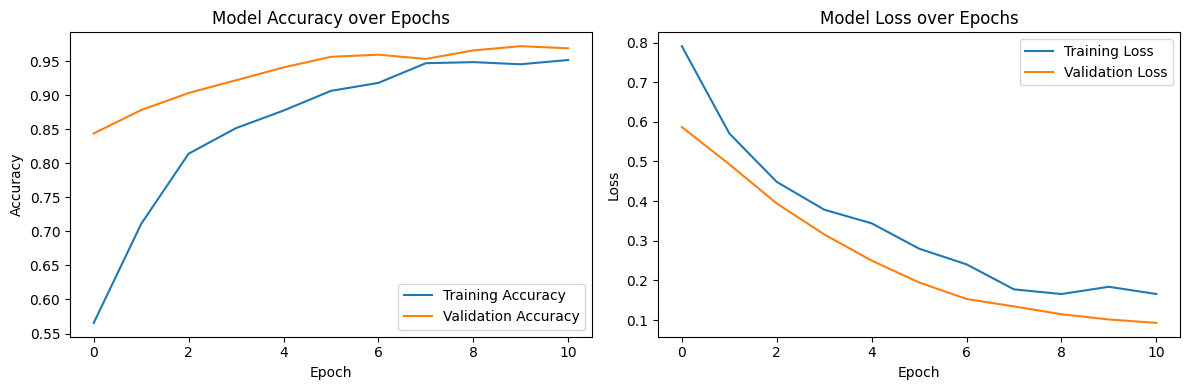

Training accuracy: 0.9800
Testing accuracy: 0.9725


In [82]:
def evaluate_model(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Visualisasi hasil training
evaluate_model(history)

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

# 5. Prediction System

In [83]:
def prediksi_kehadiran(hari_string, jam_jadwal, kondisi_cuaca, jam_masuk=None):
    """
    Memprediksi kehadiran menggunakan data cuaca dari database

    Args:
        hari_string (str): Nama hari dalam bahasa Inggris (e.g., 'Monday', 'Tuesday', etc.)
        jam_jadwal (str): Waktu jadwal dalam format "HH:MM:SS"
        kondisi_cuaca (str): Kondisi cuaca dari database backend
        jam_masuk (str, optional): Waktu kedatangan dalam format "HH:MM:SS". 
                                 Jika None, akan menggunakan jam_jadwal + 1 jam untuk simulasi
    """
    # Konversi nama hari ke angka (0-6)
    hari_ke_angka = {
        'Monday': 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6
    }
    hari = hari_ke_angka.get(hari_string, 0)  # Default ke Senin jika tidak dikenal

    # Konversi waktu jadwal dari string "HH:MM:SS" ke menit
    jam, menit, _ = map(int, jam_jadwal.split(':'))
    waktu_jadwal = jam * 60 + menit

    # Konversi waktu kedatangan
    if jam_masuk:
        jam, menit, _ = map(int, jam_masuk.split(':'))
        waktu_kedatangan = jam * 60 + menit
    else:
        # Jika tidak ada jam_masuk, gunakan jam_jadwal + 1 jam untuk simulasi
        waktu_kedatangan = waktu_jadwal + 60

    # Menghitung selisih waktu (dalam menit)
    selisih_waktu = waktu_kedatangan - waktu_jadwal

    # Memetakan kondisi cuaca ke kategori yang digunakan saat training
    peta_cuaca = {
        'Clear': [1, 0, 0],  # weather_0
        'Clouds': [0, 1, 0],  # weather_1
        'Rain': [0, 0, 1],   # weather_2
        'Thunderstorm': [0, 0, 1]  # Thunderstorm treated same as Rain
    }
    cuaca_vector = peta_cuaca.get(kondisi_cuaca, [1, 0, 0])  # Default to Clear if unknown

    # Menyiapkan fitur-fitur dalam urutan yang sama dengan training
    fitur = [
        waktu_jadwal,                    # scheduled_time
        waktu_kedatangan,                # arrival_time (waktu kedatangan aktual atau simulasi)
        hari,                            # day_of_week
        1 if hari == 0 else 0,           # is_monday
        1 if hari == 4 else 0,           # is_friday
        cuaca_vector[0],                 # weather_0
        cuaca_vector[1],                 # weather_1
        cuaca_vector[2]                  # weather_2
    ]

    # Mengubah ke numpy array dan melakukan scaling
    fitur_array = np.array([fitur])
    fitur_scaled = scaler.transform(fitur_array)

    # Mendapatkan probabilitas prediksi menggunakan model
    prediksi = float(model.predict(fitur_scaled)[0][0])

    # Menentukan toleransi berdasarkan cuaca
    toleransi = 5 if kondisi_cuaca in ['Rain', 'Thunderstorm'] else 1

    # Menentukan keterlambatan berdasarkan selisih waktu dan toleransi
    is_terlambat = selisih_waktu > toleransi  # Terlambat jika selisih waktu lebih dari toleransi

    return {
        'probabilitas_prediksi': prediksi,
        'kondisi_cuaca': kondisi_cuaca,
        'toleransi_menit': toleransi,
        'kemungkinan_terlambat': is_terlambat,
        'waktu_jadwal': jam_jadwal,
        'waktu_kedatangan': jam_masuk if jam_masuk else f"{(waktu_kedatangan // 60):02d}:{(waktu_kedatangan % 60):02d}:00",
        'selisih_menit': selisih_waktu
    }

In [84]:
def save_model_artifacts():
    # Membuat direktori model jika belum ada
    os.makedirs('model', exist_ok=True)
    
    # Menyimpan model dalam format H5
    model.save('model/absensi_model.h5')
    print("✅ Model saved as 'model/absensi_model.h5'")
    
    # Menyimpan scaler
    joblib.dump(scaler, 'model/scaler.joblib')
    print("✅ Scaler saved as 'model/scaler.joblib'")
    
    # Menyimpan metadata model
    metadata = {
        'features': features,
        'input_shape': X_train_scaled.shape[1],
        'training_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy),
        'weather_map': {
            'Clear': [1, 0, 0],
            'Clouds': [0, 1, 0],
            'Rain': [0, 0, 1],
            'Thunderstorm': [0, 0, 1]
        },
        'day_map': {
            'Monday': 0,
            'Tuesday': 1,
            'Wednesday': 2,
            'Thursday': 3,
            'Friday': 4,
            'Saturday': 5,
            'Sunday': 6
        },
        'tolerances': {
            'Rain': 5,
            'Thunderstorm': 5,
            'Clear': 1,
            'Clouds': 1
        }
    }
    
    with open('model/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print("✅ Model metadata saved as 'model/model_metadata.json'")

# Menyimpan model dan artifacts
save_model_artifacts()

✅ Model saved as 'model/absensi_model.h5'
✅ Scaler saved as 'model/scaler.joblib'
✅ Model metadata saved as 'model/model_metadata.json'

✅ Scaler saved as 'model/scaler.joblib'
✅ Model metadata saved as 'model/model_metadata.json'


# 6. Inference

In [85]:
hari_uji = 'Monday'  # Using string day name now
waktu_jadwal = '09:00:00'  # Using HH:MM:SS format now
cuaca_uji = 'Rain'

# Memanggil fungsi prediksi_kehadiran dengan argumen yang sesuai
hasil = prediksi_kehadiran(hari_string=hari_uji, jam_jadwal=waktu_jadwal, kondisi_cuaca=cuaca_uji)

print('Hasil prediksi:', hasil)

def print_hasil_prediksi(test_name, hasil):
    print(f"\n=== {test_name} ===")
    print(f"Jadwal: {hasil['waktu_jadwal']}")
    print(f"Kedatangan: {hasil['waktu_kedatangan']}")
    print(f"Kondisi Cuaca: {hasil['kondisi_cuaca']}")
    print(f"Selisih: {hasil['selisih_menit']} menit")
    print(f"Toleransi: {hasil['toleransi_menit']} menit")
    print(f"Status: {'TERLAMBAT ⚠️' if hasil['kemungkinan_terlambat'] else 'TEPAT WAKTU ✅'}")
    print('-' * 50)

# Test Case 1: Keterlambatan Ekstrim 
hasil1 = prediksi_kehadiran(
    hari_string='Sunday',
    jam_jadwal='09:00:00',
    jam_masuk='17:15:03',  # Sangat terlambat 
    kondisi_cuaca='Clouds'
)
print_hasil_prediksi('Test 1: Keterlambatan Ekstrim', hasil1)

# Test Case 2: Cuaca Buruk dengan Keterlambatan
hasil2 = prediksi_kehadiran(
    hari_string='Monday',
    jam_jadwal='08:00:00',
    jam_masuk='08:30:00',  # 30 menit terlambat
    kondisi_cuaca='Thunderstorm'
)
print_hasil_prediksi('Test 2: Cuaca Buruk (30 Menit Terlambat)', hasil2)

# Test Case 3: Datang Lebih Awal
hasil3 = prediksi_kehadiran(
    hari_string='Wednesday',
    jam_jadwal='09:00:00',
    jam_masuk='08:55:00',  # 5 menit lebih awal
    kondisi_cuaca='Clear'
)
print_hasil_prediksi('Test 3: Datang Lebih Awal', hasil3)

# Test Case 4: Tepat Waktu
hasil4 = prediksi_kehadiran(
    hari_string='Wednesday',
    jam_jadwal='09:00:00',
    jam_masuk='09:00:00',  # Tepat waktu
    kondisi_cuaca='Clear'
)
print_hasil_prediksi('Test 4: Tepat Waktu', hasil4)

# Test Case 5: Terlambat dalam Toleransi (Hujan)
hasil5 = prediksi_kehadiran(
    hari_string='Wednesday',
    jam_jadwal='09:00:00',
    jam_masuk='09:02:00',  # 2 menit terlambat
    kondisi_cuaca='Rain'
)
print_hasil_prediksi('Test 5: Terlambat dalam Toleransi (Hujan)', hasil5)

# Test Case 6: Terlambat Melebihi Toleransi (Hujan)
hasil6 = prediksi_kehadiran(
    hari_string='Wednesday',
    jam_jadwal='09:00:00',
    jam_masuk='09:06:00',  # 6 menit terlambat
    kondisi_cuaca='Rain'
)
print_hasil_prediksi('Test 6: Terlambat Melebihi Toleransi (Hujan)', hasil6)

c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Hasil prediksi: {'probabilitas_prediksi': 2.223126569715194e-14, 'kondisi_cuaca': 'Rain', 'toleransi_menit': 5, 'kemungkinan_terlambat': True, 'waktu_jadwal': '09:00:00', 'waktu_kedatangan': '10:00:00', 'selisih_menit': 60}
Hasil prediksi: {'probabilitas_prediksi': 2.223126569715194e-14, 'kondisi_cuaca': 'Rain', 'toleransi_menit': 5, 'kemungkinan_terlambat': True, 'waktu_jadwal': '09:00:00', 'waktu_kedatangan': '10:00:00', 'selisih_menit': 60}


c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Test 1: Keterlambatan Ekstrim ===
Jadwal: 09:00:00
Kedatangan: 17:15:03
Kondisi Cuaca: Clouds
Selisih: 495 menit
Toleransi: 1 menit
Status: TERLAMBAT ⚠️
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
=== Test 1: Keterlambatan Ekstrim ===
Jadwal: 09:00:00
Kedatangan: 17:15:03
Kondisi Cuaca: Clouds
Selisih: 495 menit
Toleransi: 1 menit
Status: TERLAMBAT ⚠️
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

=== Test 2: Cuaca Buruk (30 Menit Terlambat) ===
Jadwal: 08:00:00
Kedatangan: 08:30:00
Kondisi Cuaca: Thunderstorm
Selisih: 30 menit
Toleransi: 5 menit
Status: TERLAMBAT ⚠️
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
=== Test 2: Cuaca Buruk (30 Menit Terlambat) ===
Jadwal: 08:00:00
Kedatangan: 08:30:00
Kondisi Cuaca: Thunderstorm
Selisih: 30 men

c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Test 3: Datang Lebih Awal ===
Jadwal: 09:00:00
Kedatangan: 08:55:00
Kondisi Cuaca: Clear
Selisih: -5 menit
Toleransi: 1 menit
Status: TEPAT WAKTU ✅
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
=== Test 3: Datang Lebih Awal ===
Jadwal: 09:00:00
Kedatangan: 08:55:00
Kondisi Cuaca: Clear
Selisih: -5 menit
Toleransi: 1 menit
Status: TEPAT WAKTU ✅
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

=== Test 4: Tepat Waktu ===
Jadwal: 09:00:00
Kedatangan: 09:00:00
Kondisi Cuaca: Clear
Selisih: 0 menit
Toleransi: 1 menit
Status: TEPAT WAKTU ✅
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Test 4: Tepat Waktu ===
Jadwal: 09:00:00
Kedatangan: 09:00:00
Kondisi Cuaca: Clear
Selisih: 0 menit
Toleransi: 1 menit
Status: TEPAT WAKTU ✅
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Test 5: Terlambat dalam Toleransi (Hujan) ===
Jadwal: 09:00:00
Kedatangan: 09:02:00
Kondisi Cuaca: Rain
Selisih: 2 menit
Toleransi: 5 menit
Status: TEPAT WAKTU ✅
--------------------------------------------------

=== Test 5: Terlambat dalam Toleransi (Hujan) ===
Jadwal: 09:00:00
Kedatangan: 09:02:00
Kondisi Cuaca: Rain
Selisih: 2 menit
Toleransi: 5 menit
Status: TEPAT WAKTU ✅
--------------------------------------------------


c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\OneDrive - student.gunadarma.ac.id\Documents\DICODING\DBS\CAPSTONE\modeling\venv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Test 6: Terlambat Melebihi Toleransi (Hujan) ===
Jadwal: 09:00:00
Kedatangan: 09:06:00
Kondisi Cuaca: Rain
Selisih: 6 menit
Toleransi: 5 menit
Status: TERLAMBAT ⚠️
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

=== Test 6: Terlambat Melebihi Toleransi (Hujan) ===
Jadwal: 09:00:00
Kedatangan: 09:06:00
Kondisi Cuaca: Rain
Selisih: 6 menit
Toleransi: 5 menit
Status: TERLAMBAT ⚠️
--------------------------------------------------
